In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../src/')

import unet
from unet import utils
from unet.datasets import circles

In [2]:
train_dataset, validation_dataset = circles.load_data(1000, nx=256, ny=256, splits=(0.8, 0.2))
train_dataset = train_dataset.repeat(10)
validation_dataset = validation_dataset.repeat(10)

In [3]:
from tensorflow.python import ipu

cfg = ipu.config.IPUConfig()
# Request 1 IPU
cfg.auto_select_ipus = 1
# Apply the configuration
cfg.configure_ipu_system()

In [4]:
with ipu.ipu_strategy.IPUStrategy(enable_dataset_iterators=False).scope():
    unet_model = unet.build_model(channels=circles.channels,
                                  num_classes=circles.classes,
                                  layer_depth=3,
                                  filters_root=16)
    unet.finalize_model(unet_model)
    
    trainer = unet.Trainer(checkpoint_callback=False)    
    trainer.fit(unet_model,
                train_dataset,
                validation_dataset,
                epochs=5,
                batch_size=2)
    
    prediction = unet_model.predict(validation_dataset.batch(batch_size=1, drop_remainder=True))

Epoch 1/5
4000/4000 [==============================] - 19s 5ms/step - loss: 0.0783 - categorical_crossentropy: 0.0783 - categorical_accuracy: 0.9846 - mean_iou: 0.7038 - dice_coefficient: 0.9546 - auc: 0.9927
Epoch 2/5
4000/4000 [==============================] - 14s 3ms/step - loss: 0.0217 - categorical_crossentropy: 0.0217 - categorical_accuracy: 0.9947 - mean_iou: 0.8390 - dice_coefficient: 0.9900 - auc: 0.9989
Epoch 3/5
4000/4000 [==============================] - 14s 3ms/step - loss: 0.0177 - categorical_crossentropy: 0.0177 - categorical_accuracy: 0.9957 - mean_iou: 0.8695 - dice_coefficient: 0.9922 - auc: 0.9990
Epoch 4/5
4000/4000 [==============================] - 14s 3ms/step - loss: 0.0151 - categorical_crossentropy: 0.0151 - categorical_accuracy: 0.9965 - mean_iou: 0.8894 - dice_coefficient: 0.9936 - auc: 0.9991
Epoch 5/5
4000/4000 [==============================] - 13s 3ms/step - loss: 0.0138 - categorical_crossentropy: 0.0138 - categorical_accuracy: 0.9968 - mean_iou: 0.8

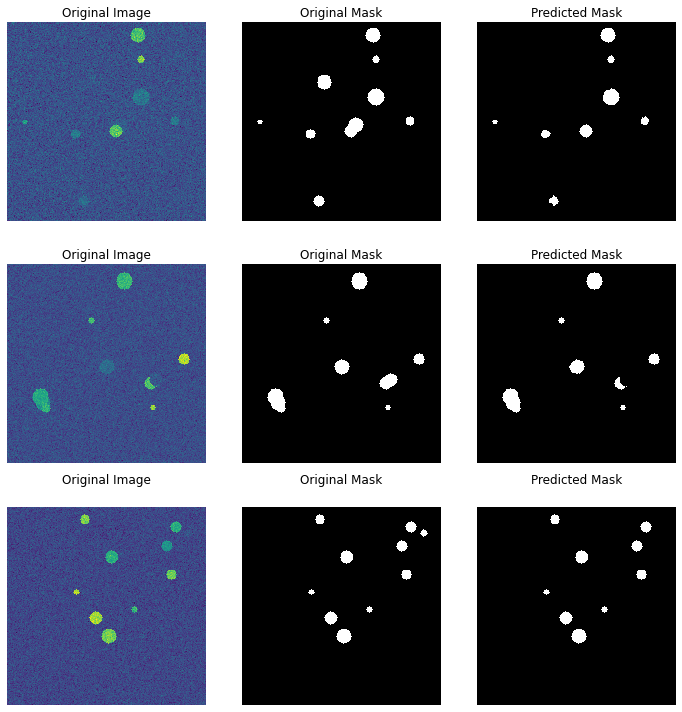

In [5]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
dataset = validation_dataset.map(utils.crop_image_and_label_to_shape(prediction.shape[1:]))

for i, (image, label) in enumerate(dataset.take(3)):
    ax[i][0].matshow(image[..., -1]); ax[i][0].set_title('Original Image'); ax[i][0].axis('off')
    ax[i][1].matshow(np.argmax(label, axis=-1), cmap=plt.cm.gray); ax[i][1].set_title('Original Mask'); ax[i][1].axis('off')
    ax[i][2].matshow(np.argmax(prediction[i,...], axis=-1), cmap=plt.cm.gray); ax[i][2].set_title('Predicted Mask'); ax[i][2].axis('off')
plt.tight_layout()